# Generating real-life test set

In [1]:
from rdkit import Chem
from rdkit import DataStructs
import pandas as pd
import numpy as np
from rdkit.Chem.MolStandardize import rdMolStandardize
import matplotlib.pyplot as plt

Reading in the file that has all the information about MassBank data, and was generated in `Mass_spectrometric_preprocessing_I.Rmd`.
Also checking if the `SMILES` field is empty and removing the instances if `True`.

In [2]:
mass_data_stand = pd.read_csv('mass_data_to_standardisation.tsv', sep='\t')
mass_data_stand[mass_data_stand['SMILES'].isnull()].to_csv('need_annotation.tsv', sep='\t')
mass_data_stand = mass_data_stand[-mass_data_stand['SMILES'].isnull()]
mass_data_stand = mass_data_stand.reset_index(drop=True)

Reading in the `original dataset`that was generated in `Tox21_pewpeocessing_II.ipynb`.

In [3]:
final_data = pd.read_csv('final_data_ready.tsv', sep='\t')

Standardising the SMILES notations in MassBank file and then matching the data in file with a cleaned Tox21 dataset (based on standardised SMILES)

In [4]:
def neutralize_atoms(mol):
    pattern = Chem.MolFromSmarts("[+1!h0!$([*]~[-1,-2,-3,-4]),-1!$([*]~[+1,+2,+3,+4])]")
    at_matches = mol.GetSubstructMatches(pattern)
    at_matches_list = [y[0] for y in at_matches]
    if len(at_matches_list) > 0:
        for at_idx in at_matches_list:
            atom = mol.GetAtomWithIdx(at_idx)
            chg = atom.GetFormalCharge()
            hcount = atom.GetTotalNumHs()
            atom.SetFormalCharge(0)
            atom.SetNumExplicitHs(hcount - chg)
            atom.UpdatePropertyCache()
    return mol

In [5]:
final_data['in_massbank'] = np.nan
mass_data_stand['needed'] = np.nan

mols = [Chem.MolFromSmiles(m) for m in mass_data_stand['SMILES']]
fps = [Chem.RDKFingerprint(m) for m in mols]
list_mass = []
for mol in mols:
    neutralize_atoms(mol)
    new_smiles = Chem.MolToSmiles(mol)
    list_mass.append(new_smiles)
mass_data_stand['SMILES_stand'] = list_mass

In [6]:
for i in range(len(final_data)):
    smi1 = final_data.iloc[i]['SMILES']
    for j in range(len(mass_data_stand)):
        smi2 = mass_data_stand.iloc[j]['SMILES_stand']
        if smi1 == smi2:
            #print(final_data.iloc[i]['SMILES'], mass_data_stand.iloc[j]['SMILES'])
            final_data.at[i, 'in_massbank'] = True
            mass_data_stand.at[j, 'needed'] = True

in_massbank = final_data[final_data['in_massbank'] == True].reset_index(drop=True)
not_in_massbank = final_data[final_data['in_massbank'] != True].reset_index(drop=True)

In [7]:
mass_data_final_new = mass_data_stand[['file_name', 'SMILES', 'SMILES_stand', 'instrument_type', 'needed']]
mass_data_final_new = mass_data_final_new[mass_data_final_new['needed'] == True]
final_data = final_data[final_data.columns[0:14]] 
final_data[final_data.columns[1:13]] = final_data[final_data.columns[1:13]].astype('Int64')
in_massbank = final_data[final_data['in_massbank'] == True].reset_index(drop=True)

Calculating the fractions of active, inactive and inconclusive compounds in each bioassay in the Tox21 dataset, and then sampling the dataset repeatedly, until the subset resembles these proportions. (Using 10% of all the compounds for generating the real-life test set.)

In [8]:
summary_stat_input = final_data[final_data.columns[1:13]].apply(pd.value_counts, dropna=False)
summary_stat_input = summary_stat_input * 0.1
summary_stat_input = summary_stat_input.round(0).astype('Int64')
summary_stat_input

,nr.ahr,nr.ar.lbd,nr.ar,nr.aromatase,nr.er.lbd,nr.er,nr.ppar.gamma,sr.are,sr.atad5,sr.hse,sr.mmp,sr.p53
0,550,624,662,527,632,515,600,470,650,585,466,608
<NA>,123,102,56,194,83,155,132,189,73,129,193,100
1,75,23,31,28,33,78,17,89,25,34,88,40


In [9]:
summary_in_massbank = in_massbank[in_massbank.columns[1:13]].apply(pd.value_counts, dropna=False)
summary_in_massbank 

,nr.ahr,nr.ar.lbd,nr.ar,nr.aromatase,nr.er.lbd,nr.er,nr.ppar.gamma,sr.are,sr.atad5,sr.hse,sr.mmp,sr.p53
0,1211,1452,1550,1141,1451,1120,1344,1057,1534,1392,989,1385
1,278,63,93,118,118,238,54,278,67,94,283,121
<NA>,206,180,52,436,126,337,297,360,94,209,423,189


Since `nr.ar` has less `NaN` values than needed based on calculated fractions - selecting all the compounds that have `NaN`in this bioassay.
After that sampling (as described) the dataset to obtain the subset with the previously calculated fractions.

In [11]:
final_selection = in_massbank[in_massbank['nr.ar'].isnull()].sample(n = 52)
final_selection[final_selection.columns[1:13]].apply(pd.value_counts, dropna=False)

,nr.ahr,nr.ar.lbd,nr.ar,nr.aromatase,nr.er.lbd,nr.er,nr.ppar.gamma,sr.are,sr.atad5,sr.hse,sr.mmp,sr.p53
<NA>,38,38,52,44,36,38,37,7,37,5,37,36
0,10,13,<NA>,6,13,7,14,37,12,45,9,14
1,4,1,<NA>,2,3,7,1,8,3,2,6,2


In [ ]:
min_error = 99999
min_index = 0
for i in range(100000):
    #Trying different bioassays for sampling and calculating the n-s based on the bioassay used
    sample_mass1 = in_massbank[in_massbank['nr.er'] == 1].sample(n = 71, random_state=i) 
    sample_mass2 = in_massbank[in_massbank['nr.er'] == 0].sample(n = 508, random_state=i)
    sample_mass3 = in_massbank[in_massbank['nr.er'].isnull()].sample(n = 117, random_state=i)
    sample_mass = pd.concat([sample_mass1, sample_mass2, sample_mass3, final_selection])
    stat = sample_mass[sample_mass.columns[1:13]].apply(pd.value_counts, dropna=False)
    error = 0
    for j in range(0,12):
        error += abs(summary_stat_input.loc[1][j] - stat.loc[1][j])
    if error < min_error:
        min_error = error
        min_index = i
        #print(min_error)

In [12]:
sample_mass1 = in_massbank[in_massbank['nr.ahr'] == 1].sample(n = 71, random_state=157277) 
sample_mass2 = in_massbank[in_massbank['nr.ahr'] == 0].sample(n = 540, random_state=157277)
sample_mass3 = in_massbank[in_massbank['nr.ahr'].isnull()].sample(n = 85, random_state=157277)
sample_mass = pd.concat([sample_mass1, sample_mass2, sample_mass3, final_selection])
stat = sample_mass[sample_mass.columns[1:13]].apply(pd.value_counts, dropna=False)
sample_mass.to_csv('validation_set.tsv', sep='\t', index=False)

After finding a suitable subset, splitting the original dataset to training set and real-life test sets.

In [19]:
train_test_set = final_data[~final_data['SMILES'].isin(sample_mass.SMILES)] # For training the models
train_test_set = train_test_set.drop(['in_massbank'], axis=1).reset_index(drop=True)
validation_set = sample_mass.drop(['in_massbank'], axis=1).reset_index(drop=True) # Real-life test set for final evaluation

In [20]:
validation_set_final = sample_mass.merge(mass_data_final_new, left_on='SMILES', right_on='SMILES_stand')
validation_set_final = validation_set_final.drop(['in_massbank', 'needed', 'SMILES_stand'], axis=1).rename(columns={'SMILES_x': 'SMILES', 'SMILES_y': 'SMILES_MB'})

In [22]:
validation_set[validation_set.columns[1:]] = validation_set[validation_set.columns[1:]].astype('Int64')
train_test_set[train_test_set.columns[1:]] = train_test_set[train_test_set.columns[1:]].astype('Int64')
validation_set_final[validation_set_final.columns[1:13]] = validation_set_final[validation_set_final.columns[1:13]].astype('Int64')

In [ ]:
# Saving the files
validation_set.to_csv('validation_set.tsv', sep='\t', index=False)
train_test_set.to_csv('train_test_set.tsv', sep='\t', index=False)
validation_set_final.to_csv('validation_set_final.tsv', sep='\t', index=False)

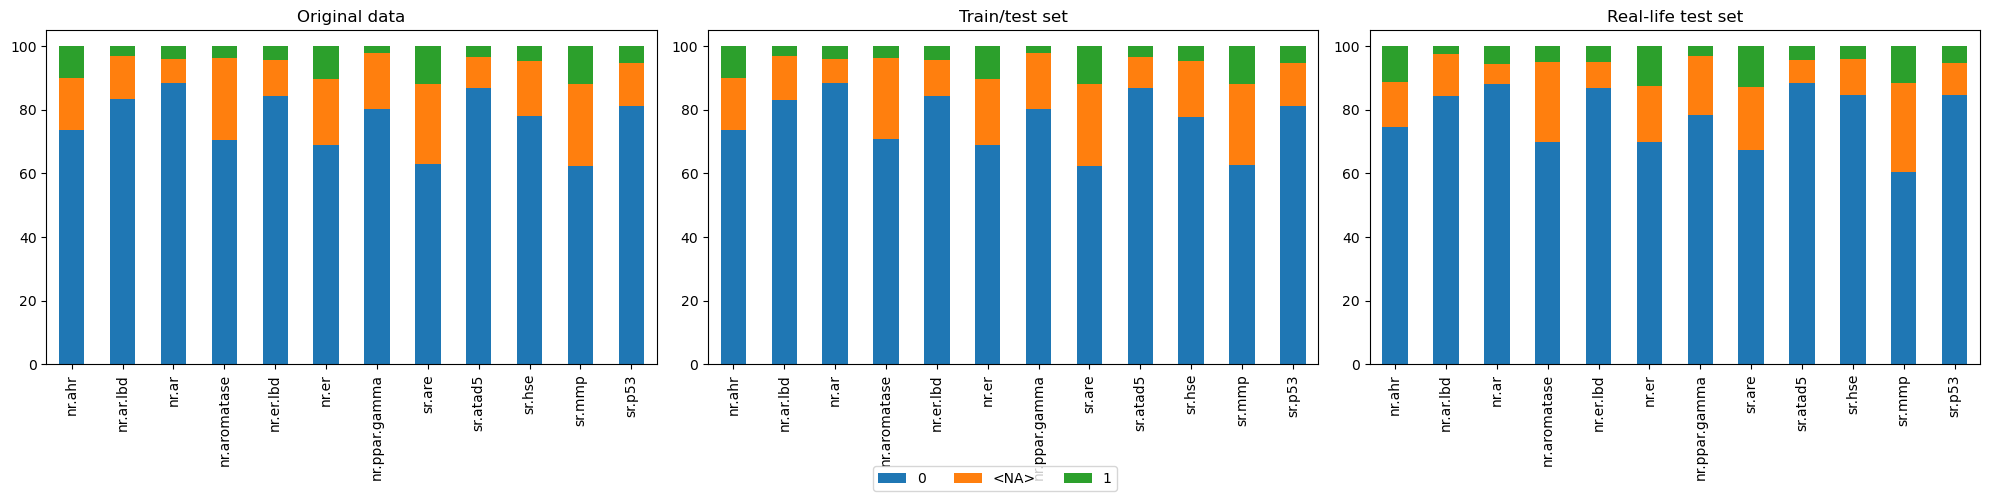

In [28]:
original_stat = final_data[final_data.columns[1:13]].apply(pd.value_counts, dropna=False).transpose().apply(lambda x: x*100/sum(x), axis=1)
train_test_stat = train_test_set[train_test_set.columns[1:13]].apply(pd.value_counts, dropna=False).transpose().apply(lambda x: x*100/sum(x), axis=1)
validation_stat = validation_set[validation_set.columns[1:13]].apply(pd.value_counts, dropna=False).transpose().apply(lambda x: x*100/sum(x), axis=1)

#stacked_data2.plot(kind="bar", stacked=True)

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
original_stat.plot( kind="bar", stacked=True, ax=axs[0], legend=False)
train_test_stat.plot( kind="bar", stacked=True, ax=axs[1], legend=False)
validation_stat.plot( kind="bar", stacked=True, ax=axs[2], legend=False)
axs[0].set_title('Original data')
axs[1].set_title('Train/test set')
axs[2].set_title('Real-life test set')
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc = 'lower center', ncol=5, labelspacing=0.)
plt.tight_layout()

Adding the information about previously calculated true fingerprint features (generated in `SMILES2fingerprint_features.Rmd`)

In [29]:
data_with_fps = pd.read_csv('general_mode_data_without_all0.tsv', sep='\t')
data_with_fps[data_with_fps.columns[1:]] = data_with_fps[data_with_fps.columns[1:]].astype('Int64')

In [30]:
train_test_set_fps = data_with_fps[data_with_fps['SMILES'].isin(train_test_set.SMILES)].reset_index(drop=True)
validation_set_fps = data_with_fps[data_with_fps['SMILES'].isin(validation_set.SMILES)].reset_index(drop=True)
validation_set_fps.to_csv('validation_set_fps.tsv', sep='\t', index=False)
train_test_set_fps.to_csv('train_test_set_fps.tsv', sep='\t', index=False)